In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [2]:
# Payoff matrices for Player A and Player B
payoffs = {
    "A": np.array([[4, 0], [5, 1]]), 
    "B": np.array([[4, 5], [0, 1]])
}

alpha_values = [0.1, 0.3, 0.5, 0.7]
gamma_values = [0.9, 0.95, 0.99]
epsilon_values = [0.6, 0.8, 1.0]
decay_rate_values = [0.001, 0.01, 0.1]

In [3]:
# Define parameter ranges
alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma_values = [0.9, 0.95, 0.99]
epsilon_values = [0.6, 0.8, 1.0]
decay_rate_values = [0.001, 0.01, 0.1]
min_epsilon = 0.01

# Grid search: create all combinations of parameters
param_combinations = list(product(alpha_values, gamma_values, epsilon_values, decay_rate_values))

# Store results
results = []

# Helper function for epsilon-greedy action selection
def choose_action(Q_column, epsilon):
    if np.random.rand() < epsilon:
        # Random action (exploration)
        return np.random.choice([0, 1])  # 0 = "C", 1 = "D"
    else:
        # Greedy action (exploitation)
        max_actions = np.flatnonzero(Q_column == Q_column.max())
        randomChoice = np.random.choice(max_actions)
        return randomChoice

# Epsilon decay function
def epsilon_decay(epsilon, min_epsilon, decay_rate, episode):
    return max(min_epsilon, epsilon * np.exp(-decay_rate * episode))

# Iterate over all parameter combinations
for alpha, gamma, epsilon, decay_rate in param_combinations:
    # Reset variables for each run
    Q_A = np.zeros((2, 1))
    Q_B = np.zeros((2, 1))

    epsilon_start = epsilon
    
    coop_A_count = 0
    coop_B_count = 0
    track_cooperation = []

    # Run Q-learning simulation with the current parameters
    for episode in range(1, 10001):  # Run for 1000 episodes
        epsilon = epsilon_decay(epsilon, min_epsilon, decay_rate, episode)  # Decay epsilon
        
        # Choose actions using epsilon-greedy
        action_A = choose_action(Q_A, epsilon)
        action_B = choose_action(Q_B, epsilon)
        
        if action_A == 0:
            coop_A_count += 1
        if action_B == 0:
            coop_B_count += 1
        
        reward_A = payoffs["A"][action_A, action_B]
        reward_B = payoffs["B"][action_A, action_B]
        
        # Update Q-tables
        Q_A[action_A] += alpha * (reward_A + gamma * np.max(Q_A) - Q_A[action_A])
        Q_B[action_B] += alpha * (reward_B + gamma * np.max(Q_B) - Q_B[action_B])
        
        # Track cooperation every 100 episodes
        if episode % 100 == 0:
            track_cooperation.append({
                "episode": episode,
                "cooperation_A": coop_A_count / 100,
                "cooperation_B": coop_B_count / 100
            })
            coop_A_count = 0
            coop_B_count = 0

    # Compute average cooperation for the last 100 episodes
    coop_A_final = np.mean([x["cooperation_A"] for x in track_cooperation[-10:]])  # Last 10 tracked episodes
    coop_B_final = np.mean([x["cooperation_B"] for x in track_cooperation[-10:]])

    # Store result
    results.append({
        "alpha": alpha,
        "gamma": gamma,
        "epsilon": epsilon_start,
        "decay_rate": decay_rate,
        "coop_A_final": coop_A_final,
        "coop_B_final": coop_B_final
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find the best parameter combination
best_params = results_df.loc[results_df['coop_A_final'].idxmax()]
print(f"Best parameters: \n{best_params}")

# Plot the cooperation rates for the best parameters
best_results = results_df.loc[results_df['alpha'] == best_params['alpha']]



Best parameters: 
alpha           0.100
gamma           0.990
epsilon         0.600
decay_rate      0.001
coop_A_final    0.994
coop_B_final    0.992
Name: 18, dtype: float64


In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(results_df)

     alpha  gamma  epsilon  decay_rate  coop_A_final  coop_B_final
0      0.1   0.90      0.6       0.001         0.956         0.985
1      0.1   0.90      0.6       0.010         0.005         0.004
2      0.1   0.90      0.6       0.100         0.006         0.005
3      0.1   0.90      0.8       0.001         0.982         0.985
4      0.1   0.90      0.8       0.010         0.004         0.003
5      0.1   0.90      0.8       0.100         0.003         0.002
6      0.1   0.90      1.0       0.001         0.007         0.004
7      0.1   0.90      1.0       0.010         0.003         0.003
8      0.1   0.90      1.0       0.100         0.005         0.007
9      0.1   0.95      0.6       0.001         0.002         0.006
10     0.1   0.95      0.6       0.010         0.007         0.006
11     0.1   0.95      0.6       0.100         0.004         0.004
12     0.1   0.95      0.8       0.001         0.005         0.006
13     0.1   0.95      0.8       0.010         0.009         0

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
results_df

,alpha,gamma,epsilon,decay_rate,coop_A_final,coop_B_final
0,0.1,0.90,0.6,0.001,0.956,0.985
1,0.1,0.90,0.6,0.010,0.005,0.004
2,0.1,0.90,0.6,0.100,0.006,0.005
3,0.1,0.90,0.8,0.001,0.982,0.985
4,0.1,0.90,0.8,0.010,0.004,0.003
...,...,...,...,...,...,...
130,0.9,0.99,0.8,0.010,0.978,0.976
131,0.9,0.99,0.8,0.100,0.005,0.004
132,0.9,0.99,1.0,0.001,0.983,0.988
133,0.9,0.99,1.0,0.010,0.979,0.972


In [7]:
print(results_df.columns)

Index(['alpha', 'gamma', 'epsilon', 'decay_rate', 'coop_A_final',
       'coop_B_final'],
      dtype='object')


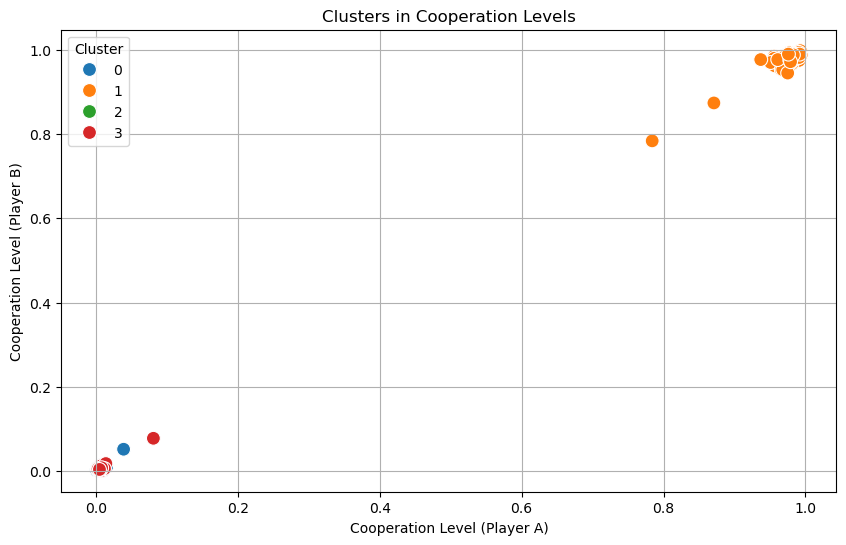

            alpha     gamma   epsilon  coop_A_final  coop_B_final
cluster                                                          
0        0.256757  0.971622  0.805405      0.006757      0.007351
1        0.605085  0.948983  0.789831      0.973102      0.974695
2        0.264706  0.900000  0.823529      0.004235      0.004412
3        0.809091  0.934545  0.800000      0.010364      0.009364


In [8]:

# Example: Simulated results_df
# Columns: ['alpha', 'gamma', 'epsilon', 'cooperation_A', 'cooperation_B']
#results_df = pd.DataFrame({
    #'alpha': np.random.uniform(0.1, 1.0, 100),
    #'gamma': np.random.uniform(0.5, 1.0, 100),
    #'epsilon': np.random.uniform(0.1, 0.8, 100),
    #'cooperation_A': np.random.uniform(0, 1, 100),
    #'cooperation_B': np.random.uniform(0, 1, 100),
#})

# Normalize the data
scaler = StandardScaler()
features = ['alpha', 'gamma', 'epsilon','coop_A_final', 'coop_B_final']
normalized_data = scaler.fit_transform(results_df[features])

# Apply k-means clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
results_df['cluster'] = kmeans.fit_predict(normalized_data)

# Visualize clusters in cooperation space
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=results_df['coop_A_final'],
    y=results_df['coop_B_final'],
    hue=results_df['cluster'],
    palette='tab10',
    s=100,
)
plt.title("Clusters in Cooperation Levels")
plt.xlabel("Cooperation Level (Player A)")
plt.ylabel("Cooperation Level (Player B)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

# Analyze parameter ranges for each cluster
cluster_summary = results_df.groupby('cluster')[['alpha', 'gamma', 'epsilon', 'coop_A_final', 'coop_B_final']].mean()
print(cluster_summary)
